In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
from torch.utils.data import DataLoader


print(torch.backends.mps.is_available()) 
print(torch.backends.mps.is_built())     
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#device = "cuda" if torch.cuda.is_available() else "cpu"


True
True


In [2]:
device

device(type='mps')

In [3]:
class ResidualBlock(nn.Module):
    """
    helps the model to learn the residual of the input and the output
    skips some layers to avoid vanishing gradient problem
    
    """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels) # Added batch normalization
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels) # Added batch normalization

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return x + residual #residual connection.
        

In [4]:
class Generator(nn.Module):
    """
    the actual Generator model for the SRGAN
    that uses the resblocks and pixel shuffle to upsample the image
    
    """
    def __init__(self):
        super(Generator, self).__init__()
        
        #first convo2d layer
        self.initial = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        
        #residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(16)]) # Increase number of residual blocks
        #this 4 is the batch size!

        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),  # 2x
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),  # 4x
            nn.ReLU(inplace=True),
        )
        
        self.output = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        x = self.initial(x)
        res = self.res_blocks(x)
        x = x + res #residual connection.
        x = self.upsample(x)
        
        return torch.tanh(self.output(x))
        
        
    

In [5]:
class Discriminator(nn.Module):
    """
    determines if the image is real or fake (generated by sgan or not)
    
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def conv_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
            
        self.model = nn.Sequential(
            conv_block(3, 64, 1),
            conv_block(64, 128, 2),
            conv_block(128, 256, 2),
            conv_block(256, 512, 2),
            nn.AdaptiveAvgPool2d((4, 4)), # Add adaptive average pooling
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024), # Adjust linear layer size
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            #removed nn.Sigmoid()
        )
        #sigmoid is to convert the output to a probability

    def forward(self, x):
        return self.model(x)

        

In [6]:
gen = Generator().to(device)
disc = Discriminator().to(device)

optimizer_G = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=(0.9, 0.999))
#build our optimizers with the models made

In [7]:
transform_high_res = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
#this function will resize the image to 256x256 and normalize the image also tensorize it

In [8]:
transforms_low_res = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [9]:
class SuperResData(Dataset):
    
    """
    dataset that will hold the high res and low res images and also the image paths
    """
    def __init__(self, hr_dir, transform_hr, transform_lr):
        self.hr_dir = hr_dir
        self.transform_hr = transform_hr
        self.transform_lr = transform_lr
        self.images = os.listdir(hr_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        hr_path = os.path.join(self.hr_dir, self.images[idx])
        image = Image.open(hr_path).convert("RGB")
        
        hr_image = self.transform_hr(image)
        lr_image = self.transform_lr(image)
        
        return lr_image, hr_image

In [10]:
image_data = SuperResData("archive/DIV2K_train_HR/DIV2K_train_HR", transform_high_res, transforms_low_res)

In [11]:
image_data.__getitem__(799)
#test to make sure it works

(tensor([[[-0.9294, -0.8353, -0.8353,  ...,  0.9451,  0.5608,  0.2863],
          [-0.9216, -0.9216, -0.8510,  ...,  0.9216,  0.4902,  0.1216],
          [-0.9294, -0.9294, -0.8902,  ...,  0.5843,  0.1137, -0.1294],
          ...,
          [-0.5608, -0.2157, -0.1686,  ...,  0.0275, -0.1608, -0.2078],
          [-0.6078, -0.1451, -0.0510,  ..., -0.1216, -0.3725, -0.1529],
          [-0.6078, -0.3804,  0.0588,  ..., -0.1451, -0.3412,  0.0588]],
 
         [[-0.8745, -0.7725, -0.7569,  ...,  0.9529,  0.6235,  0.4196],
          [-0.8745, -0.8667, -0.7804,  ...,  0.9294,  0.5686,  0.2627],
          [-0.8667, -0.8745, -0.8275,  ...,  0.6392,  0.2235, -0.0275],
          ...,
          [-0.3804, -0.0431,  0.0118,  ...,  0.0353, -0.1608, -0.2157],
          [-0.4824, -0.0353,  0.0980,  ..., -0.1373, -0.3804, -0.1529],
          [-0.5765, -0.3098,  0.1765,  ..., -0.1294, -0.2784,  0.0980]],
 
         [[-0.9059, -0.8353, -0.8745,  ...,  0.8902, -0.1059, -0.8824],
          [-0.8980, -0.9373,

In [12]:

#now we will make the dataloader
subset_dataset = torch.utils.data.Subset(image_data, range(0, 200))  # Use first 100 images
dataloader = DataLoader(subset_dataset, batch_size=4, shuffle=True, num_workers=0)
#dataloader = DataLoader(image_data, batch_size=4, shuffle=True, num_workers=0)




In [13]:
"""
for i, (low_res,real_images) in enumerate(dataloader):
real_images = real_images.to(device)
low_res = low_res.to(device)
print(f"Batch {i+1}:")
print(f"High-res image shape: {real_images.shape}")
print(f"Low-res image shape: {low_res.shape}")

fake_images = gen(low_res)
print(f"Generated image shape: {fake_images.shape}")
dis = disc(real_images)
print(f"Discriminator output for real images: {dis}")
#fake_dis = disc(fake_images)
#print(f"Discriminator output for fake images: {fake_dis}")

print("-" * 50)

"""


'\nfor i, (low_res,real_images) in enumerate(dataloader):\nreal_images = real_images.to(device)\nlow_res = low_res.to(device)\nprint(f"Batch {i+1}:")\nprint(f"High-res image shape: {real_images.shape}")\nprint(f"Low-res image shape: {low_res.shape}")\n\nfake_images = gen(low_res)\nprint(f"Generated image shape: {fake_images.shape}")\ndis = disc(real_images)\nprint(f"Discriminator output for real images: {dis}")\n#fake_dis = disc(fake_images)\n#print(f"Discriminator output for fake images: {fake_dis}")\n\nprint("-" * 50)\n\n'

In [14]:
#next we train the model in epochs!
#generative adversarial network

criterion = nn.BCEWithLogitsLoss()  # For the discriminator
mse_loss = nn.MSELoss()


def GAN_epochs(num_epochs):
    for epoch in range(num_epochs):
        for i, (low_res, real_images) in enumerate(dataloader):
            
            real_images = real_images.to(device)
            low_res = low_res.to(device)
            
            fake_images = gen(low_res)
            
            
            #print(f"Real Images Shape: {real_images.shape}")  
            #print(f"Fake Images Shape: {fake_images.shape}")  


            real_output = disc(real_images)
            fake_output = disc(fake_images)
            
            loss_real = criterion(real_output, torch.ones_like(real_output))
            #real images should be 1
            
            loss_fake = criterion(fake_output, torch.zeros_like(fake_output))
            #fake images should be 0
            
            loss_D = (loss_real + loss_fake) / 2
            #total loss for the discriminator
            
            optimizer_D.zero_grad()
            loss_D.backward(retain_graph=True)
            optimizer_D.step()
            
            #now we have to update the generator
            fake_output = disc(fake_images)
            loss_G = criterion(fake_output, torch.ones_like(fake_output))
            #train this model to trick the discriminator and give 1 to fake images!
            
            #use the mse loss to make the images more realistic
            mse_loss_value = mse_loss(fake_images, real_images)
            total_loss_G = loss_G + mse_loss_value 
            
            optimizer_G.zero_grad()
            total_loss_G.backward()
            optimizer_G.step()
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")
            


In [15]:
GAN_epochs(25)

Epoch [1/25], Loss D: 0.6926342248916626, Loss G: 0.9495959281921387
Epoch [1/25], Loss D: 0.6895202398300171, Loss G: 0.9058811664581299
Epoch [1/25], Loss D: 0.5918099880218506, Loss G: 1.0520026683807373
Epoch [1/25], Loss D: 0.6119235754013062, Loss G: 0.9598549604415894
Epoch [1/25], Loss D: 0.6445515155792236, Loss G: 1.0369147062301636
Epoch [1/25], Loss D: 0.568941593170166, Loss G: 1.1633232831954956
Epoch [1/25], Loss D: 0.7535240650177002, Loss G: 1.1099282503128052
Epoch [1/25], Loss D: 0.7560360431671143, Loss G: 0.7354778051376343
Epoch [1/25], Loss D: 0.59630286693573, Loss G: 0.9313088059425354
Epoch [1/25], Loss D: 0.5841426849365234, Loss G: 1.173011064529419
Epoch [1/25], Loss D: 0.7088745832443237, Loss G: 0.9802119731903076
Epoch [1/25], Loss D: 0.608993649482727, Loss G: 1.1321954727172852
Epoch [1/25], Loss D: 0.6917810440063477, Loss G: 1.1422423124313354
Epoch [1/25], Loss D: 0.7020180225372314, Loss G: 0.9772685170173645
Epoch [1/25], Loss D: 0.678066730499267

In [16]:
#takes 20 minutes to train on 200 images

def save_models(gen, disc, epoch, save_dir="model"):
    """
    Saves the generator and discriminator models.

    Args:
        gen (nn.Module): The generator model.
        disc (nn.Module): The discriminator model.
        epoch (int): The current epoch number.
        save_dir (str): The directory to save the models.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    gen_path = os.path.join(save_dir, f"gen_epoch_{epoch}.pth")
    disc_path = os.path.join(save_dir, f"disc_epoch_{epoch}.pth")

    torch.save(gen.state_dict(), gen_path)
    torch.save(disc.state_dict(), disc_path)

    print(f"Models saved at epoch {epoch} to {save_dir}/")

def load_models(gen, disc, epoch, save_dir="model"):
    """
    Loads the generator and discriminator models.

    Args:
        gen (nn.Module): The generator model.
        disc (nn.Module): The discriminator model.
        epoch (int): The epoch number of the models to load.
        save_dir (str): The directory where the models are saved.
    """

    gen_path = os.path.join(save_dir, f"gen_epoch_{epoch}.pth")
    disc_path = os.path.join(save_dir, f"disc_epoch_{epoch}.pth")

    try:
        gen.load_state_dict(torch.load(gen_path))
        disc.load_state_dict(torch.load(disc_path))
        print(f"Models loaded from epoch {epoch} from {save_dir}/")
    except FileNotFoundError:
        print(f"Error: Models for epoch {epoch} not found in {save_dir}/")
        return False

    return True



In [17]:
save_models(gen=gen, disc=disc, epoch=25, save_dir="model")

Models saved at epoch 25 to model/


In [18]:
#epochs take approx 20 minutes to run on my machine cpu


import matplotlib.pyplot as plt 
import torchvision.transforms as transforms


In [19]:

def test_model(generator, dataset, device, idx=0):
    """ 
    Tests the generator by visualizing a low-res image, 
    its corresponding high-res image, and the generated high-res image.
    """
    # Pick a random index from the dataset
    
    # Get the low-res and high-res images
    low_res, high_res = dataset[idx]
    
    # Move low-res image to device and add batch dimension
    low_res = low_res.unsqueeze(0).to(device)  # Shape: (1, 3, 64, 64)

    # Generate the high-res image
    with torch.no_grad():
        fake_high_res = generator(low_res).cpu().squeeze(0)  # Remove batch dim

    # Convert images back to PIL format for visualization
    def tensor_to_pil(tensor):
        tensor = tensor * 0.5 + 0.5  # Unnormalize
        return transforms.ToPILImage()(tensor.clamp(0, 1))

    low_res_img = tensor_to_pil(low_res.squeeze(0))  # Remove batch dim
    high_res_img = tensor_to_pil(high_res)
    fake_high_res_img = tensor_to_pil(fake_high_res)

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(low_res_img)
    ax[0].set_title("Low-Resolution Input")
    ax[0].axis("off")

    ax[1].imshow(high_res_img)
    ax[1].set_title("Real High-Resolution")
    ax[1].axis("off")

    ax[2].imshow(fake_high_res_img.convert("RGB"))
    ax[2].set_title("Generated High-Resolution")
    ax[2].axis("off")

    plt.show()

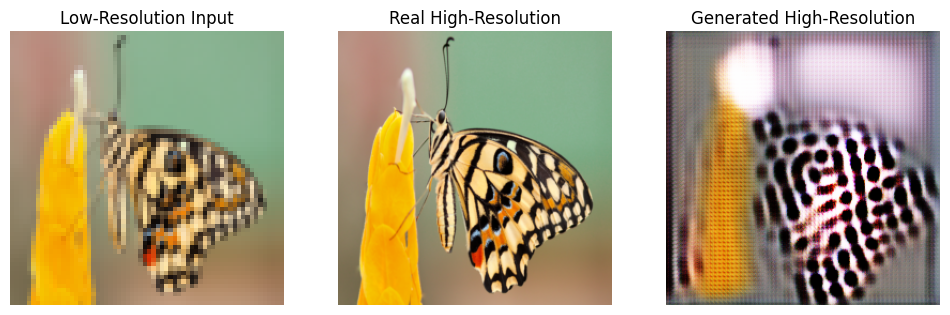

In [27]:
test_model(gen, image_data, device, idx=1)